In [120]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.distance import cdist
import sklearn 
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

train_split = pd.read_csv('subsplit_train_data.csv')
train_split = train_split.drop('KIBA', axis = 1)
train, test = sklearn.model_selection.train_test_split(train_split, test_size=.25, random_state=42, shuffle=True, stratify=train_split['Label'])

#corr = train.corr()

In [93]:
# Feature Selection 
X = train.drop('Label', axis = 1)
y = train['Label']

k_best = SelectKBest(mutual_info_classif, k=50) # might want to update feature selection method / change k val
train_fs = k_best.fit(X, y)
cols = k_best.get_support(indices=True)
train_fs = train.iloc[:,cols]

In [94]:
# Outlier Removal 

# box plot pre-OR ?
preOL_mean = train_fs.mean()
preOL_med = train_fs.median()

Q1 = train_fs.quantile(0.25)
Q3 = train_fs.quantile(0.75)

IQR = Q3-Q1

# this sets outliers to Nan
# train_or=train_fs[~((train_fs<(Q1-1.5*IQR)) | (train_fs>(Q3+1.5*IQR)))]

# this relaces outliers with the corresponding bound 
train_or=train_fs[(train_fs>(Q1-1.5*IQR))]
train_or = train_or.fillna(Q1-1.5*IQR)
train_or = train_or[(train_fs<(Q3+1.5*IQR))]
train_or = train_or.fillna(Q3+1.5*IQR)

postOL_mean = train_or.mean()
postOL_med = train_or.median()
# box plot post OR ?

OLdescriptor_frames = [preOL_mean, preOL_med, postOL_mean, postOL_med]
OLdescriptor_names = ['preOL_mean', 'preOL_med', 'postOL_mean', 'postOL_med']

OLdescriptor = pd.concat(OLdescriptor_frames, axis = 1)
OLdescriptor.columns = OLdescriptor_names
#print(OLdescriptor)

In [95]:
# Normalization 

# min max normalization 
train_mmnorm = train_or
for column in train_mmnorm.columns:
    col = train_mmnorm[column]
    num = col - col.min()
    denom = col.max()-col.min()
    train_mmnorm[column] = num/denom
#print(train_mmnorm)

# z-score normalization 
#train_znorm = train_or
#for column in train_znorm.columns:
#    col = train_znorm[column]
#    num = col - col.mean()
#    denom = col.std()
#    train_znorm[column] = num/denom

#print(train_znorm)

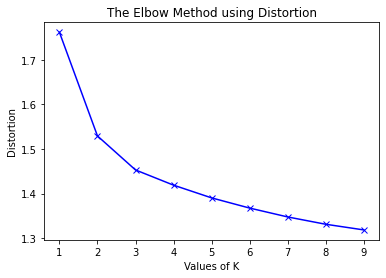

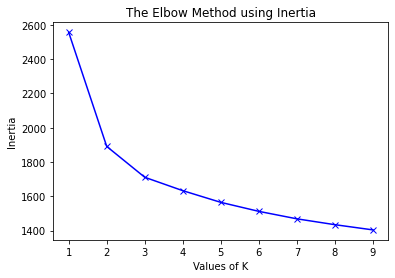

In [96]:
# elbow plot 2 find k 
# adapted from : https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
distortion = []
inertia = []
m1 = {}
m2 = {}

for k in range(1,10):
    kmm = KMeans(n_clusters=k).fit(train_mmnorm)
    dist = sum(np.min(cdist(train_mmnorm, kmm.cluster_centers_,'euclidean'), axis=1)) / train_mmnorm.shape[0]
    inert = kmm.inertia_
    
    distortion.append(dist)
    m1[k] = dist
    
    inertia.append(inert)
    m2[k] = kmm.inertia_

    
plt.plot(range(1,10), distortion, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()
    
plt.plot(range(1,10), inertia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [101]:
# k means classifier 
k_means = KMeans(init='k-means++', n_clusters=3, n_init=10) # n_clusters based on elbow plots! 
km_classiier = k_means.fit(train_mmnorm)

km_train = k_means.predict(train_mmnorm)

train_cluster = train_mmnorm
train_cluster['Cluster'] = list(km_train)
train_cluster['Label'] = y # if outliers are handeled differently (dropped) this will break 

In [118]:
# train learning algorithm for each cluster

cluster1 = train_cluster[train_cluster['Cluster']==0]
yc1 = cluster1['Label']
Xc1 = cluster1.drop(['Label', 'Cluster'], axis = 1)
xgb_c1train = xgb.DMatrix(Xc1, label=yc1)

#cluster2 = train_cluster[train_cluster['Cluster']==1]
#cluster3 = train_cluster[train_cluster['Cluster']==2]
# etc 

default_params = {'learning_rate': 0.1,
 'n_estimators':1000,
 'max_depth':4,
 'min_child_weight':1,
 'min_split_loss':0, #gamma
 'subsample':0.8,
 'colsample_bytree':0.8,
 'objective': 'binary:logistic',
 'scale_pos_weight': 0.25,
 'seed':42,
 'tree_method':'hist'}

xgb_c1model = xgb.train(default_params, xgb_c1train)
# etc 

[12:45:16] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:45:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [122]:
# for test set 
X = test.drop('Label', axis = 1)
y = test['Label']

# feature selection fron train
test_fs = k_best.fit(X, y)
test_fs = train.iloc[:,cols]

# outlier replacement using train set 
#test_or = test_fs[(test_fs>(Q1-1.5*IQR))]
#test_or = test_or.fillna(Q1-1.5*IQR)
#test_or = test_or[(test_fs<(Q3+1.5*IQR))]
#test_or = test_or.fillna(Q3+1.5*IQR)

# normalization?
# create test_mmnorm

km_test = k_means.predict(test_mmnorm)

test_cluster = test_mmnorm
test_cluster['Cluster'] = list(km_test)
test_cluster['Label'] = y

cluster1 = test_cluster[test_cluster['Cluster']==0]
yc1 = cluster1['Label']
Xc1 = cluster1.drop(['Label', 'Cluster'], axis = 1)
xgb_c1test = xgb.DMatrix(Xc1, label=yc1)

xgb_c1model.predict() 
#etccccc